## Train LSTM model for power and energy prediction

### 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import mlflow
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.optimizers import Adam
from pathlib import Path
import matplotlib.pyplot as plt

2025-03-30 00:06:02.727565: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) > 0:
    print(f"GPU is available and will be used: {gpus}")
else:
    print("No GPU detected, using CPU")

GPU is available and will be used: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 2: Define Hyperparameters

In [3]:
# Hyperparameters (previously handled by argparse)
csv_path = "/Users/kashmithnisakya/Developer/Data_Science/Energy-Prediction-System/ml/data/processed/china_mill_data_2025_03_04_09_30_30.csv"  # Replace with your actual CSV path
window_size = 336 * 4  # Input window size (e.g., 7 days = 336)
batch_size = 32
hidden_size = 50
num_layers = 2
epochs = 50
features = ['energy', 'power']  # Define features here as they were hardcoded
learning_rate = 0.001
model_name = "lstm_model_test"

### 3: Data Loading and Preprocessing Function

In [4]:
def load_and_preprocess_data(csv_path, features, window_size):
    print(f"Loading data from {csv_path}")
    df = pd.read_csv(csv_path, parse_dates=['time'])
    df = df.sort_values('time').set_index('time')
    df = df[features]

    # Store original energy for comparison
    original_energy = df['energy'].copy()

    # Handle zero values in energy (keeping initial zeros)
    print("Processing zero values in energy")
    energy = df['energy'].copy()
    mask = energy == 0
    
    # Keep initial zeros until first non-zero value
    first_nonzero_idx = energy.ne(0).idxmax()
    mask.loc[:first_nonzero_idx] = False
    
    # Replace subsequent zeros with previous non-zero value
    if mask.any():
        energy.loc[mask] = np.nan
        energy = energy.ffill()  # Updated to use ffill() instead of fillna(method='ffill')
    df['energy'] = energy
    
    # Fill any remaining NaN values
    df = df.ffill()  # Updated to use ffill() instead of fillna(method='ffill')

    # Plot original vs filtered energy
    print("Plotting original vs filtered energy")
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, original_energy, label='Original Energy', alpha=0.5, linestyle='--')
    plt.plot(df.index, df['energy'], label='Filtered Energy', alpha=0.5)
    plt.title('Original vs Filtered Energy Values')
    plt.xlabel('Time')
    plt.ylabel('Energy Value')
    plt.legend()
    plt.grid(True)
    plt.show()  # Display the plot instead of saving

    print("Scaling data")
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)

    X, y = [], []
    for i in range(window_size, len(scaled_data)):
        X.append(scaled_data[i - window_size:i])
        y.append(scaled_data[i])

    print("Creating input sequences")
    X = np.array(X)
    y = np.array(y)
    return X, y, scaler

### 4: Model Building Function

In [5]:
# Custom callback for MLflow logging per epoch
class MLflowLoggingCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        mlflow.log_metric("train_loss", logs.get('loss'), step=epoch)
        mlflow.log_metric("train_mae", logs.get('mae'), step=epoch)
        mlflow.log_metric("val_loss", logs.get('val_loss'), step=epoch)
        mlflow.log_metric("val_mae", logs.get('val_mae'), step=epoch)

In [6]:
def build_model(input_shape, hidden_size, num_layers, output_size, learning_rate):
    print("Building LSTM model")
    model = Sequential()
    model.add(LSTM(hidden_size, return_sequences=(num_layers > 1), input_shape=input_shape))
    for _ in range(1, num_layers):
        model.add(LSTM(hidden_size, return_sequences=(_ < num_layers - 1)))
    model.add(Dense(output_size))

    # Custom optimizer with specified learning rate
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

### 5: Data Preparation

Loading data from /Users/kashmithnisakya/Developer/Data_Science/Energy-Prediction-System/ml/data/processed/china_mill_data_2025_03_04_09_30_30.csv
Processing zero values in energy
Plotting original vs filtered energy


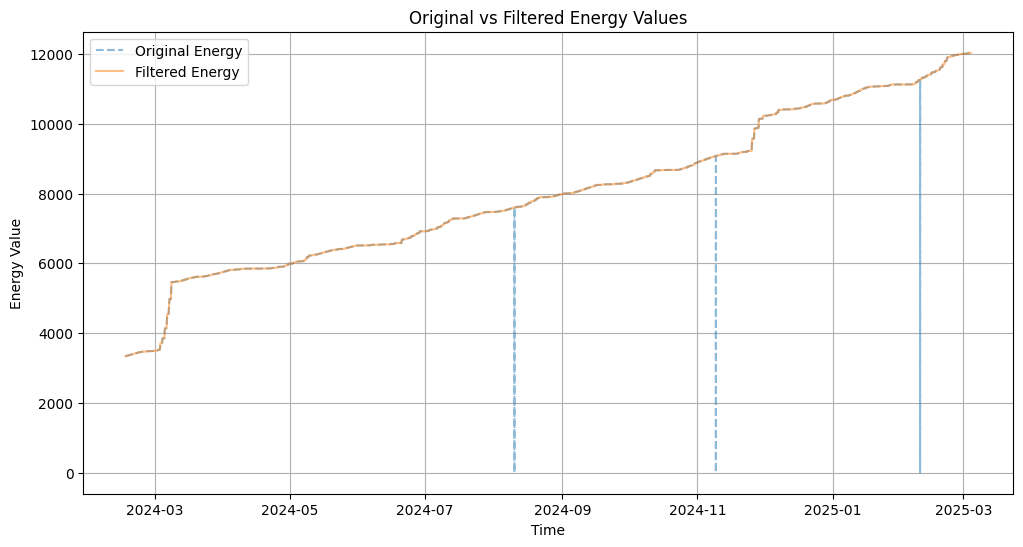

Scaling data
Creating input sequences
Training data shape: (102924, 1344, 2), (102924, 2)
Testing data shape: (25732, 1344, 2), (25732, 2)


In [7]:
# Start MLflow run
mlflow.start_run()

# Log hyperparameters
mlflow.log_params({
    "window_size": window_size,
    "batch_size": batch_size,
    "hidden_size": hidden_size,
    "num_layers": num_layers,
    "epochs": epochs
})

# Load and preprocess data
X, y, scaler = load_and_preprocess_data(csv_path, features, window_size)

# Split into train and test sets
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Print shapes for verification
print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")

### 6: Model Creation and Training

In [8]:
# Learning rate scheduler
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

In [9]:
# Build the model
model = build_model(
    input_shape=(X_train.shape[1], X_train.shape[2]),
    hidden_size=hidden_size,
    num_layers=num_layers,
    output_size=len(features),
    learning_rate=learning_rate
)

Building LSTM model


2025-03-30 00:06:06.374009: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-30 00:06:06.374063: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-03-30 00:06:06.631824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-03-30 00:06:06.632582: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] 

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1344, 50)          10600     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 2)                 102       
                                                                 
Total params: 30,902
Trainable params: 30,902
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
mlflow_callback = MLflowLoggingCallback()

In [12]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop, lr_schedule, mlflow_callback]
)

Epoch 1/50


2025-03-30 00:06:09.455234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-03-30 00:06:09.456157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-03-30 00:06:09.456739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

   1/3217 [..............................] - ETA: 1:59:52 - loss: 0.0850 - mae: 0.2207

2025-03-30 00:06:11.380452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3217/3217 [==============================] - ETA: 0s - loss: 4.2105e-04 - mae: 0.0066

2025-03-30 00:14:04.394168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-03-30 00:14:04.395010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-03-30 00:14:04.395459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3217/3217 [==============================] - 505s 156ms/step - loss: 4.2105e-04 - mae: 0.0066 - val_loss: 2.5904e-04 - val_mae: 0.0084 - lr: 0.0010
Epoch 2/50
3217/3217 [==============================] - 517s 161ms/step - loss: 2.5147e-04 - mae: 0.0050 - val_loss: 2.3480e-04 - val_mae: 0.0072 - lr: 0.0010
Epoch 3/50
3217/3217 [==============================] - 517s 161ms/step - loss: 2.3351e-04 - mae: 0.0048 - val_loss: 2.1271e-04 - val_mae: 0.0036 - lr: 0.0010
Epoch 4/50
3217/3217 [==============================] - ETA: 0s - loss: 2.2591e-04 - mae: 0.0046
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
3217/3217 [==============================] - 514s 160ms/step - loss: 2.2591e-04 - mae: 0.0046 - val_loss: 2.4399e-04 - val_mae: 0.0069 - lr: 0.0010
Epoch 5/50
3217/3217 [==============================] - 513s 160ms/step - loss: 2.1119e-04 - mae: 0.0039 - val_loss: 2.1067e-04 - val_mae: 0.0052 - lr: 5.0000e-04
Epoch 6/50
3217/3217 [============================

### 7: Model Evaluation and Saving

In [13]:
# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Log metrics to MLflow
mlflow.log_metrics({"loss": loss, "mae": mae})

# Save the model
model_path = Path(f"model/{model_name}.h5")
model.save(model_path)
mlflow.log_artifact(str(model_path))

# End MLflow run
mlflow.end_run()

print("Model training and saving completed")

805/805 [==============================] - 30s 38ms/step - loss: 2.1067e-04 - mae: 0.0052
Test Loss: 0.00021067420311737806, Test MAE: 0.005245423410087824
Model training and saving completed


### 8: Plot Predictions

2025-03-30 01:40:47.758493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-03-30 01:40:47.759133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-03-30 01:40:47.759973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

  3/805 [..............................] - ETA: 29s 

2025-03-30 01:40:47.992541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


805/805 [==============================] - 30s 37ms/step


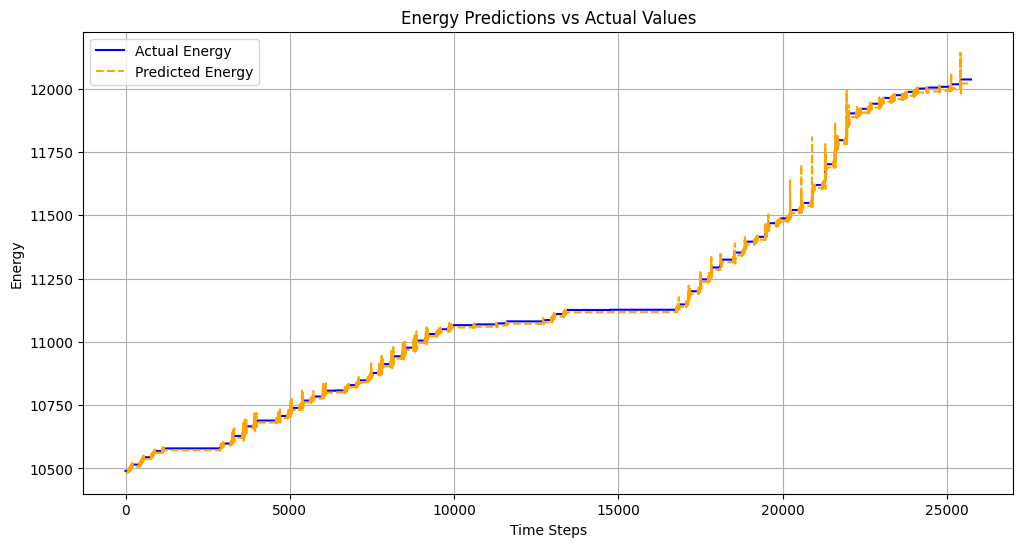

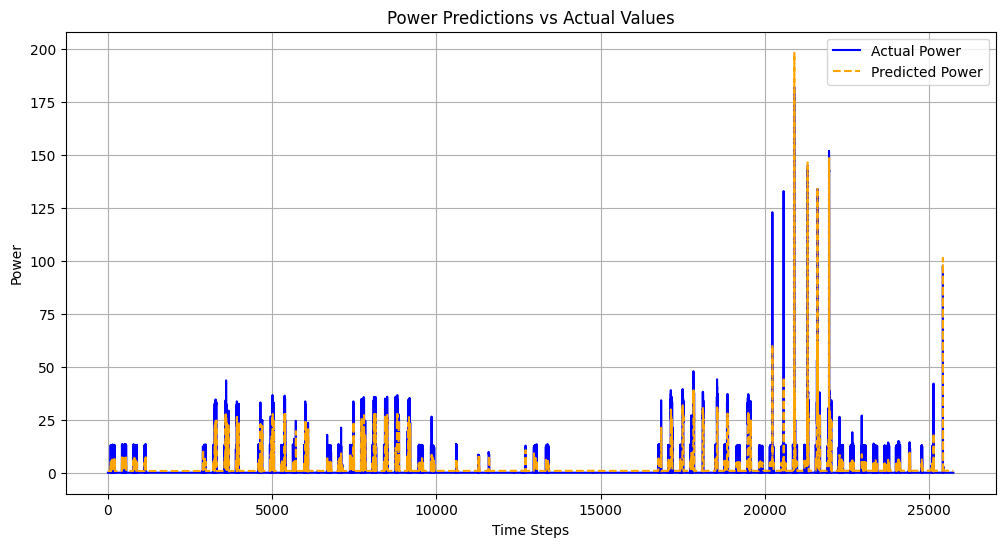

In [14]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values to original scale
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

# Plot energy predictions (first feature)
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv[:, 0], label='Actual Energy', color='blue')
plt.plot(y_pred_inv[:, 0], label='Predicted Energy', color='orange', linestyle='--')
plt.title('Energy Predictions vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Energy')
plt.legend()
plt.grid(True)
plt.show()

# Plot power predictions (second feature)
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv[:, 1], label='Actual Power', color='blue')
plt.plot(y_pred_inv[:, 1], label='Predicted Power', color='orange', linestyle='--')
plt.title('Power Predictions vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Power')
plt.legend()
plt.grid(True)
plt.show()